# An exploratory data analysis on energy data

## Table of Contents

1. [Data Background](#data-background)
1. [Import Libraries](#import-libraries)
1. [Get the Data](#get-the-data)
    1. [Take a quick look at data structure](#quick-look)
    1. [Initial Feature Engineering](#initial-fe)
1. [Discover and Visualize the Data to Gain Insights (EDA)](#eda)

<a name='background'></a>
## Data Background
In the dataset, there are three different data consist of electricity usage recorded at three different quick-service restaurants which are; QSR1, QSR2, QSR3. These restaurants are located in different countries e.g., QSR1 is located in the UK, QSR2 and QSR3 are located in Malaysia. The dataset consists of electricity usage from different readings and data channels which records the type of de- vices monitored by the electricity meter. Each reading record contains multivariate time series data from phase-1, phase-2, phase-3 or system with 60 minutes interval within specific dates.

<a name='import-libraries'></a>
## Import Libraries

In [47]:
# Essential data management libraries
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import numpy as np
import regex, re

# Aestetics of notebook
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

# Essential path management
import os
from functools import reduce

# Data Viz libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import plotly.express as px
import plotly.graph_objects as go

# Consistent plots
from pylab import rcParams

rcParams['figure.figsize'] = 20,12
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['axes.labelsize'] = 10

# Feature engineering libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, scale
from sklearn.impute import KNNImputer,SimpleImputer

# Custom libraries
from create_master_data import create_md  # Creates master_data.csv
from cpfinder.feature_engineering import to_main_phase # Groups all phases as main

<a name='get-the-data'></a>
## Get the Data

The data structured as follows starting from:

In [48]:
DATASET_FOLDER_PATH = "../Dataset"

In [49]:
# The structure inside of the folder is as follows
try:
    _, DATA_CHANNELS_PATH, QSR3_PATH, QSR2_PATH, _, QSR1_PATH = [os.path.join(DATASET_FOLDER_PATH,x) for x in os.listdir(DATASET_FOLDER_PATH)]
except ValueError:
    _, DATA_CHANNELS_PATH, QSR3_PATH, QSR2_PATH, MASTER_DATA_PATH, _, QSR1_PATH = [os.path.join(DATASET_FOLDER_PATH,x) for x in os.listdir(DATASET_FOLDER_PATH)]

# Example path 
DATA_CHANNELS_PATH

'../Dataset/data-channels.csv'

Inside of each QSR folder, there are electricity usage data as csv file from each data channels.

In [50]:
# Data channels
data_channels = pd.read_csv(DATA_CHANNELS_PATH)
data_channels.head()

organizationName      uuId  dataChannelId    channelName displayedPhase
0             QSR1  0CCD0001          59668    Main supply         system
1             QSR1  0CCD0002          59670  Center Island         system
2             QSR1  0CCD0003          59669        Dryer 1              1
3             QSR1  0CCD0003          59676  Dryer 2 and 3              2
4             QSR1  0CCD0003          59677  Dryer 4 and 5              3

In [51]:
# Since all important features selected: P, E, PF. We can combine as one tabular form for easy usage and less memory usage
create_md(data_channels, DATASET_FOLDER_PATH)
MASTER_DATA_PATH = os.path.join(DATASET_FOLDER_PATH, "master_data.csv")

100%|██████████| 55/55 [00:01<00:00, 36.17it/s]
(257252, 9)


<a name="take-a-quick-look"></a>
### Take a qucik look at data structure

In [52]:
data = pd.read_csv(MASTER_DATA_PATH, index_col=0)
data.head()

org      uuid channel_name   phase          datetime          ts  \
0  QSR1  0CCD0001  Main supply  system  2019-10-01 00:00  1569888000   
1  QSR1  0CCD0001  Main supply  system  2019-10-01 01:00  1569891600   
2  QSR1  0CCD0001  Main supply  system  2019-10-01 02:00  1569895200   
3  QSR1  0CCD0001  Main supply  system  2019-10-01 03:00  1569898800   
4  QSR1  0CCD0001  Main supply  system  2019-10-01 04:00  1569902400   

           P          E     PF  
0 12246.8989 12445.7960 0.8292  
1 13927.1655 13928.0761 0.8041  
2 11648.4463 11651.9840 0.8343  
3 10777.4771 10780.2469 0.8280  
4  9307.8740  9299.0174 0.8426

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257252 entries, 0 to 257251
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   org           257252 non-null  object 
 1   uuid          257252 non-null  object 
 2   channel_name  257252 non-null  object 
 3   phase         257252 non-null  object 
 4   datetime      257252 non-null  object 
 5   ts            257252 non-null  int64  
 6   P             238905 non-null  float64
 7   E             238889 non-null  float64
 8   PF            238905 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 19.6+ MB


In [54]:
data.describe()

ts           P            E          PF
count     257252.0000 238905.0000  238889.0000 238905.0000
mean  1583311139.3591   3529.1128    3567.3080      0.5436
std      6548119.4435  10049.8461   15438.4565      0.5194
min   1569888000.0000   -247.4877       0.0000     -1.0000
25%   1578157200.0000      1.8897       0.0002      0.3737
50%   1584331200.0000    306.3604     306.2619      0.7303
75%   1588539600.0000   1826.8214    1825.7584      0.9173
max   1594594800.0000 124986.9083 4457185.2995      1.0000

In [55]:
data.phase.value_counts()

system    151862
1          35130
2          35130
3          35130
Name: phase, dtype: int64

In [56]:
uuid_to_name = data.groupby('uuid').agg({'channel_name':pd.Series.unique})
display(uuid_to_name)

channel_name
uuid                                                       
0CCD0001                                        Main supply
0CCD0002                                      Center Island
0CCD0003            [Dryer 1, Dryer 2 and 3, Dryer 4 and 5]
0CCD0004                                              Fryer
0CCD0005                                      Air Cond Rest
0CCD0006                                    Air Con Kitchen
0CCD0007                                        Frezzer out
0CCD0008                 [Cold Room, Meat Chiller, Frezzer]
45EC0001                                 Main Incoming - 1F
45EC0002                                       Aircond - 1F
45EC0003                                     Cool Room - 1F
45EC0004                                      Lighting - 1F
45EC0005                                         Power - 1F
45EC0006                                     A/C Front - 1F
45EC0007                                    A/C Behind - 1F
466E0001                                      Incoming - 1F
466E0002                                       Aircond - 1F
466E0003                                         Power - 1F
466E0004                                      Lighting - 1F
74700001                                       Incoming - G
74700002                                          Power - G
74700003                                        Aircond - G
74700004                                      Cool Room - G
74700005                                Ventilation fan - G
74700006                                Heating Element - G
74700007                             Lighting for Dining -G
74700008                            Lighting for Kitchen -G
8D900001                                 Main Incoming - GF
8D900002                                      Aircond - GF 
8D900003                                     Cool Room - GF
8D900004                                   Ventilation - GF
8D900005                                         Power - GF
8D900006                                       Kitchen - GF
8D900007                            A/C Kitchen - GF (10HP)
8D900008                              A/C Dining - GF (6HP)
E00F0001                                  Breakfast Oven x2
E00F0002                                         Signage DB
E00F0003                                           Staff DB
E00F0004               [Extract Fan, Supply Fan, Chip Dump]
E00F0005  [1st Floor AC 3, 1st Floor AC 1/1ST Floor AC 4...
E00F0006  [Order Under Fridge, Order High Fridge, Water ...
E00F0007  [Milk Cooler, Breading Table 1, Breading Table 2]
E00F0008                                           Lighting

<a name='initial-fe'> </a>
### Initial Feature engineering 

In [57]:
data = to_main_phase(data)

In [58]:
data['datetime']=pd.to_datetime(data.datetime)

In [59]:
# meter_id from uuid
data["meter_id"] = data.uuid.str.extract(r"(^....)", expand=False)
data.meter_id.value_counts()

E00F    46840
0CCD    46840
7470    27648
8D90    27648
45EC    24192
466E    13824
Name: meter_id, dtype: int64

<a name='eda'></a>
# Discover and Visualize the Data to Gain Insights (EDA)

So far we have only taken a quick glance at the data to get a general understanding of
the kind of data we are manipulating. Now the goal is to go into a little more depth.
<a name='eda-main'></a>
## Discover and Visualize the Data

In [60]:
display(data.head())
print(f"\n{data.shape}")

org      uuid            datetime          P     PF          E meter_id
0  QSR1  0CCD0001 2019-10-01 00:00:00 12246.8989 0.8292 12445.7960     0CCD
1  QSR1  0CCD0001 2019-10-01 01:00:00 13927.1655 0.8041 13928.0761     0CCD
2  QSR1  0CCD0001 2019-10-01 02:00:00 11648.4463 0.8343 11651.9840     0CCD
3  QSR1  0CCD0001 2019-10-01 03:00:00 10777.4771 0.8280 10780.2469     0CCD
4  QSR1  0CCD0001 2019-10-01 04:00:00  9307.8740 0.8426  9299.0174     0CCD


(186992, 7)


* **org:** Name of the given quick service restaurant

In [61]:
# Number of readings data from each restaurant
print("Number of readings data from each restaurant: ")
data.org.value_counts()

Number of readings data from each restaurant: 


QSR1    93680
QSR2    51840
QSR3    41472
Name: org, dtype: int64

* **uuid:** ID of the given data channel

In [62]:
# Number of readings from each channel
print("Number of readings from each channel:")
data.uuid.value_counts().sort_index()

Number of readings from each channel:


0CCD0001    5855
0CCD0002    5855
0CCD0003    5855
0CCD0004    5855
0CCD0005    5855
0CCD0006    5855
0CCD0007    5855
0CCD0008    5855
45EC0001    3456
45EC0002    3456
45EC0003    3456
45EC0004    3456
45EC0005    3456
45EC0006    3456
45EC0007    3456
466E0001    3456
466E0002    3456
466E0003    3456
466E0004    3456
74700001    3456
74700002    3456
74700003    3456
74700004    3456
74700005    3456
74700006    3456
74700007    3456
74700008    3456
8D900001    3456
8D900002    3456
8D900003    3456
8D900004    3456
8D900005    3456
8D900006    3456
8D900007    3456
8D900008    3456
E00F0001    5855
E00F0002    5855
E00F0003    5855
E00F0004    5855
E00F0005    5855
E00F0006    5855
E00F0007    5855
E00F0008    5855
Name: uuid, dtype: int64

Seems like all of the channels has same number of readings with the corresponding meter e.g. all of the 0CCD has 5855 reading entries. Therefore there isn't any problem here.

In [63]:
print(f"Number of nan values in uuid column: {data.uuid.isna().sum()}")

Number of nan values in uuid column: 0


* **datetime:** A column that shows the datetime of the given reading

In [64]:
data.head()

org      uuid            datetime          P     PF          E meter_id
0  QSR1  0CCD0001 2019-10-01 00:00:00 12246.8989 0.8292 12445.7960     0CCD
1  QSR1  0CCD0001 2019-10-01 01:00:00 13927.1655 0.8041 13928.0761     0CCD
2  QSR1  0CCD0001 2019-10-01 02:00:00 11648.4463 0.8343 11651.9840     0CCD
3  QSR1  0CCD0001 2019-10-01 03:00:00 10777.4771 0.8280 10780.2469     0CCD
4  QSR1  0CCD0001 2019-10-01 04:00:00  9307.8740 0.8426  9299.0174     0CCD

In [65]:
dt_range = data.groupby(['org','meter_id']).agg({'datetime':['min','max']})
dt_range[('datetime','dif')]= dt_range[('datetime','max')] - dt_range[('datetime','min')]
dt_range

datetime                                      
                              min                 max               dif
org  meter_id                                                          
QSR1 0CCD     2019-10-01 00:00:00 2020-05-31 23:00:00 243 days 23:00:00
     E00F     2019-10-01 00:00:00 2020-05-31 23:00:00 243 days 23:00:00
QSR2 45EC     2020-02-20 08:00:00 2020-07-13 07:00:00 143 days 23:00:00
     8D90     2020-02-20 08:00:00 2020-07-13 07:00:00 143 days 23:00:00
QSR3 466E     2020-02-20 08:00:00 2020-07-13 07:00:00 143 days 23:00:00
     7470     2020-02-20 08:00:00 2020-07-13 07:00:00 143 days 23:00:00

* **P:** Power of the system (sum of all three phases) (W)

In [66]:
display(data.P.describe())
print(f"\nNumber of nan values in power column: {data.P.isna().sum()}")

count   186992.0000
mean      4508.8704
std      11168.6554
min       -236.4371
25%         41.1359
50%        709.9380
75%       2935.0131
max     124986.9083
Name: P, dtype: float64


Number of nan values in power column: 0


In [67]:
# Tukey's rule for outliers
display(HTML("<h4>Tukey's rule application on power column<h4/>"))
lower_bound_P = data.P.quantile(.25) - (data.P.quantile(.75)- data.P.quantile(.25))*1.5
upper_bound_P = data.P.quantile(.75) + (data.P.quantile(.75)- data.P.quantile(.25))*1.5
print(f"Lower Bound: {lower_bound_P:.2f}, Upper Bound: {upper_bound_P:.2f}\n\n")
print(f"Number of readings outside of this area: {data[ (data.P<lower_bound_P) | (data.P>upper_bound_P) ].shape[0]} \n")
print(f"Percentage of total: {data[ (data.P<lower_bound_P) | (data.P>upper_bound_P) ].shape[0]/data.shape[0]*100:.2f}%")
print("\n\nAre they outliers or changepoints?")

Lower Bound: -4299.68, Upper Bound: 7275.83


Number of readings outside of this area: 25415 

Percentage of total: 13.59%


Are they outliers or changepoints?


In [68]:
display(HTML("<h4>Readings with zero or negative power??<h4/>"))
out = data[ (data.P<lower_bound_P) | (data.P>upper_bound_P) ].shape[0]
print(f"\nZero: {data[data.P==0].shape[0]} --> {data[data.P==0].shape[0]/data.shape[0]*100:.2f}%\nNegative: {data[data.P<0].shape[0]} --> {data[data.P<0].shape[0]/data.shape[0]*100:.2f}%")
print(f"Total: {data[data.P<=0].shape[0]} --> {data[data.P<=0].shape[0]/data.shape[0]*100:.2f}%")
print(f"Outside of boundaries {out} --> {out/data.shape[0]*100:.2f}%")
print(f"Grand Total: {data[data.P<=0].shape[0]+out} --> {(data[data.P<=0].shape[0]+out)/data.shape[0]*100:.2f}%")
print("\nAre all of these problematic entries?")
del out


Zero: 12451 --> 6.66%
Negative: 14259 --> 7.63%
Total: 26710 --> 14.28%
Outside of boundaries 25415 --> 13.59%
Grand Total: 52125 --> 27.88%

Are all of these problematic entries?


<AxesSubplot:xlabel='P', ylabel='Count'>

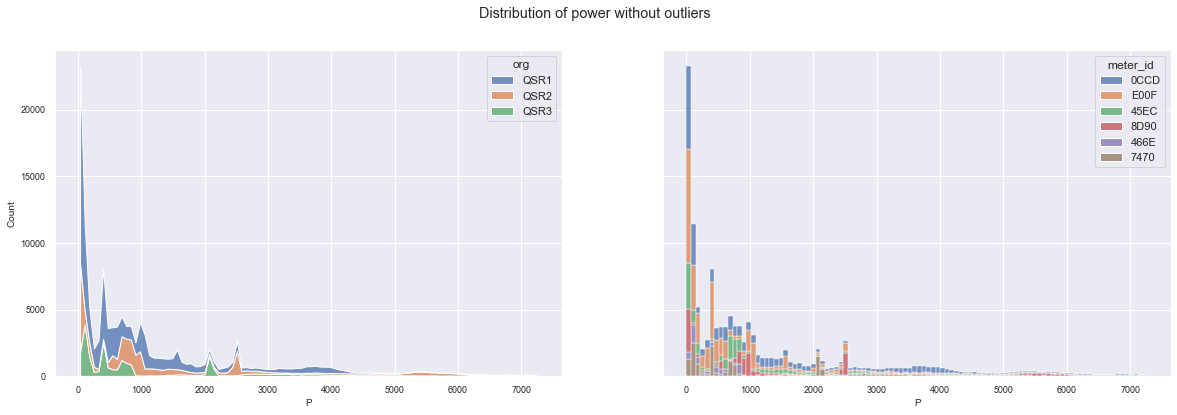

In [69]:
plotP=data[ (data.P>0) & (data.P<upper_bound_P) ]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6), sharey=True, sharex=True)
fig.suptitle("Distribution of power without outliers")
sns.histplot(
    data=plotP,
    x="P",
    hue="org",
    multiple="stack",
    element="poly",
    ax=ax1
)
sns.histplot(
    data=plotP,
    x="P",
    hue="meter_id",
    multiple="stack",
    ax=ax2
)

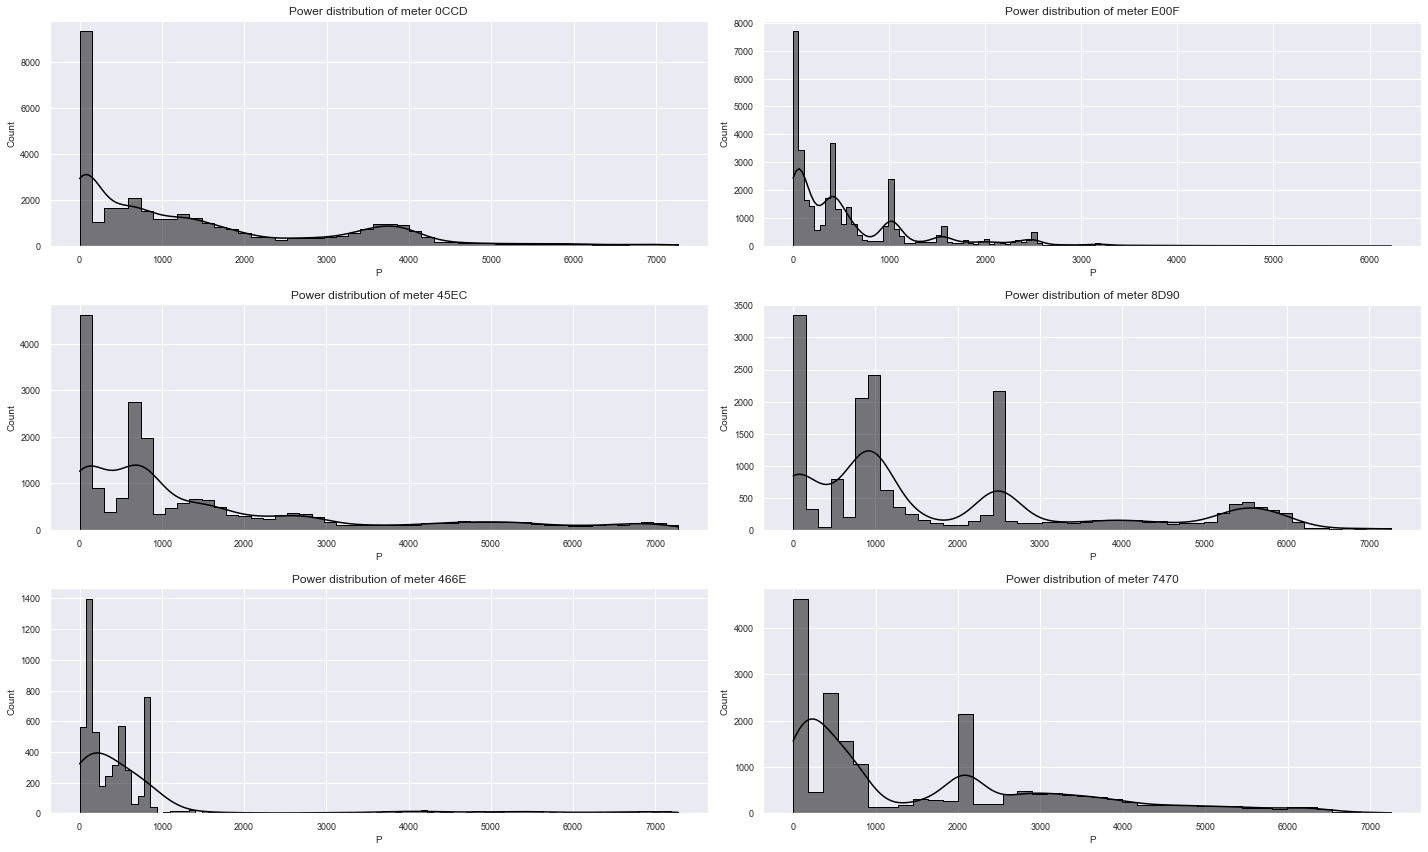

In [70]:
meter_ids = plotP.meter_id.unique()
for i, _id in enumerate(meter_ids):
    plt.subplot(3,2,(i+1))
    plt.title(f"Power distribution of meter {_id}")
    plot_meter_P=plotP[plotP.meter_id == _id]
    sns.histplot(
        data=plot_meter_P,
        x="P",
        kde=True,
        element="step",
        color='black'
    )
plt.tight_layout()

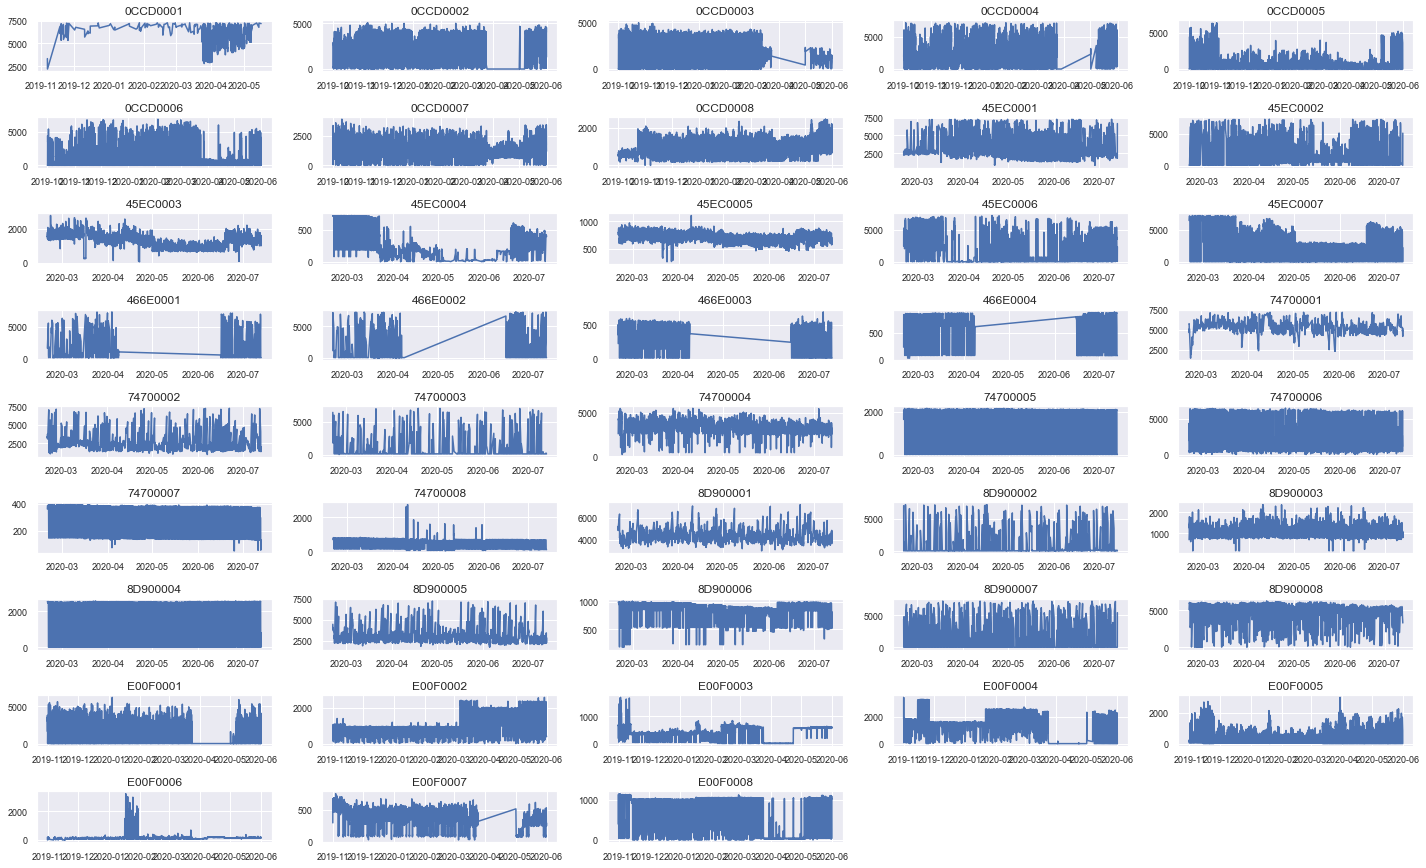

In [71]:
plt.figure(figsize=(20,20))
for i, ((uuid,meter_id), uuid_data) in enumerate(plotP.groupby(['uuid', 'meter_id'])):
    plt.subplot(15,5,i+1)
    plt.title(uuid)
    plt.plot(uuid_data.datetime, uuid_data.P)
plt.tight_layout()

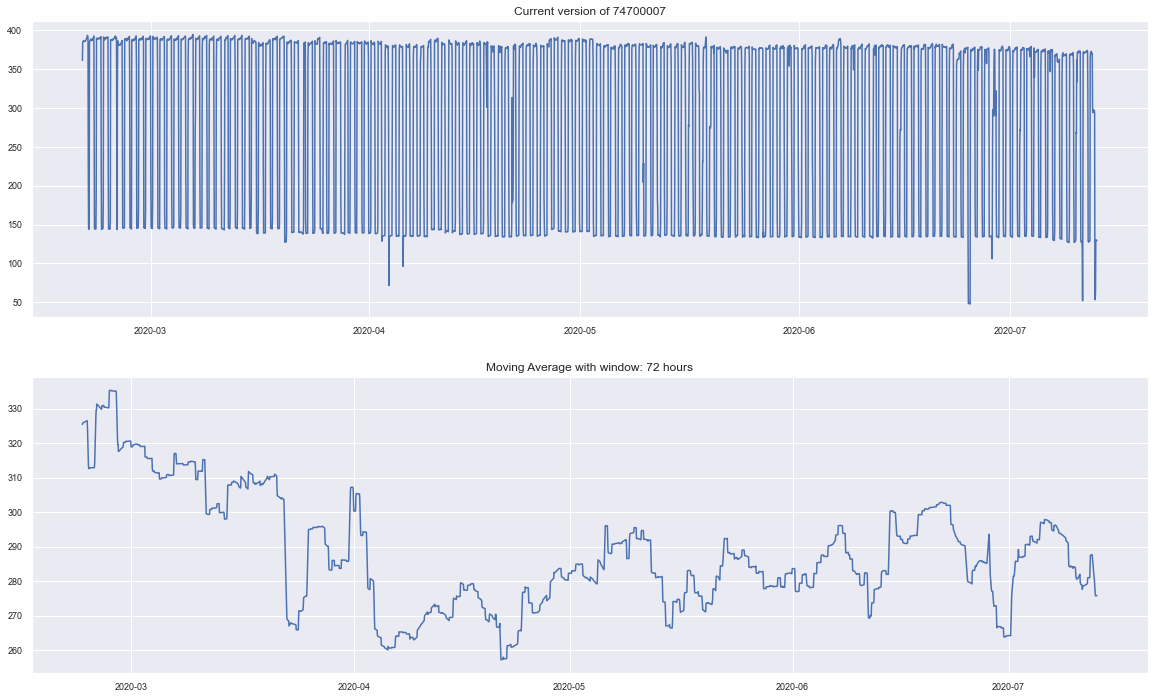

In [72]:
plt.figure(figsize=(20,12))
s = plotP[plotP.uuid=='74700007']

plt.subplot(211)
plt.title("Current version of 74700007")
plt.plot(s.datetime, s.P)

plt.subplot(212)
w=72
plt.title(f"Moving Average with window: {w} hours")
s['P_SMA_3'] = s.P.rolling(window=w).mean()
plt.plot(s.datetime,s.P_SMA_3)
del s

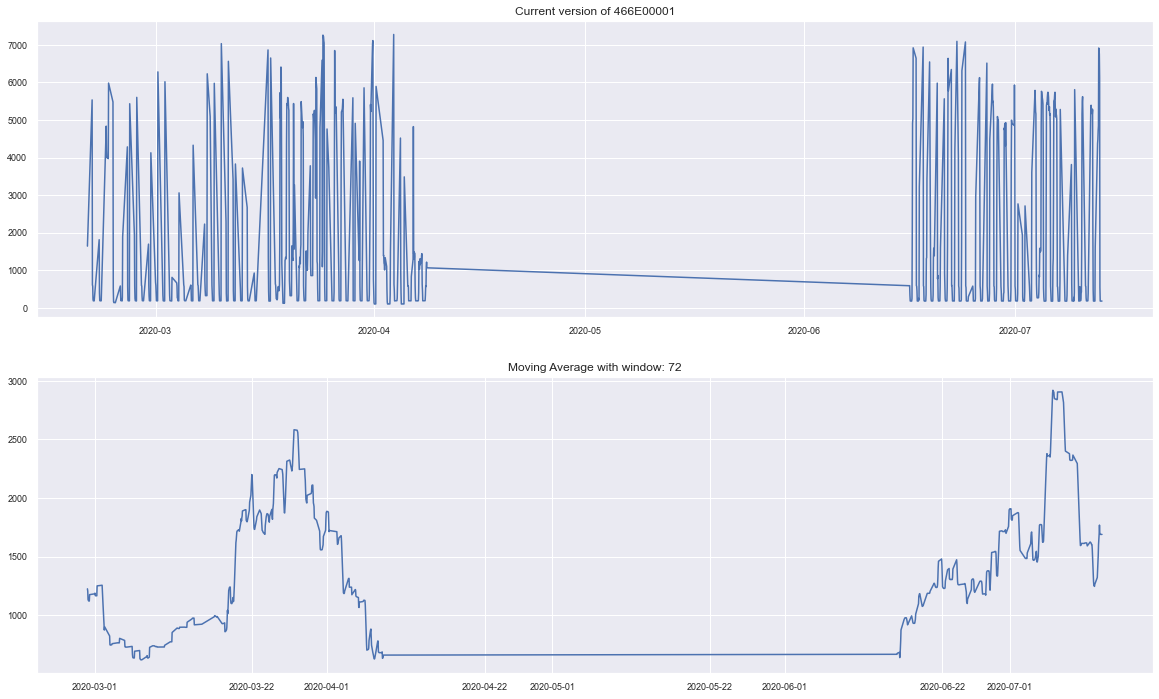

In [73]:
plt.figure(figsize=(20,12))
s = plotP[plotP.uuid=='466E0001']
plt.subplot(211)
plt.title("Current version of 466E00001")
plt.plot(s.datetime, s.P)

plt.subplot(212)
w=72
plt.title(f"Moving Average with window: {w}")
s['P_SMA_3'] = s.P.rolling(window=w).mean()
plt.plot(s.datetime,s.P_SMA_3)

del s

Time window with problematic numbers e.g. zero, negative, outlier is enourmous.

* **E:** Cumulative Nett Energy of the system (sum of all three phases) (Wh)

In [74]:
display(data.E.describe(include='all'))
print(f"\nNumber of nan values in energy column: {data.E.isna().sum()}")

count    186992.0000
mean       4557.3641
std       17323.5804
min           0.0000
25%          40.9766
50%         710.9368
75%        2933.2290
max     4457185.2995
Name: E, dtype: float64


Number of nan values in energy column: 0


In [75]:
# Tukey's rule for outliers
E = data[(data.E>=0)].E # Remove impossible values energy should be greater than or equal to 0
display(HTML("<h4>Tukey's rule application on power column<h4/>"))
lower_bound_E = E.quantile(.25) - (E.quantile(.75)- E.quantile(.25))*1.5
upper_bound_E = E.quantile(.75) + (E.quantile(.75)- E.quantile(.25))*1.5
print(f"Lower Bound: {lower_bound_E:.2f}, Upper Bound: {upper_bound_E:.2f}\n\n")
print(f"Number of readings outside of this area: {data[ (data.E<lower_bound_E) | (data.E>upper_bound_E) ].shape[0]} \n")
print(f"Percentage of total: {data[ (data.E<lower_bound_E) | (data.E>upper_bound_E) ].shape[0]/data.shape[0]*100:.2f}%")
print("\n\nAre they outliers or changepoints? Also why the numbers close with Power?")

Lower Bound: -4297.40, Upper Bound: 7271.61


Number of readings outside of this area: 25409 

Percentage of total: 13.59%


Are they outliers or changepoints? Also why the numbers close with Power?


In [76]:
display(HTML("<h4>Readings with zero or negative Energy??<h4/>"))
out = data[ (data.E<lower_bound_E) | (data.E>upper_bound_E) ].shape[0]
print(f"\nZero: {data[data.E==0].shape[0]} --> {data[data.E==0].shape[0]/data.shape[0]*100:.2f}%\nNegative: {data[data.E<0].shape[0]} --> {data[data.E<0].shape[0]/data.shape[0]*100:.2f}%")
print(f"Total: {data[data.E<=0].shape[0]} --> {data[data.E<=0].shape[0]/data.shape[0]*100:.2f}%")
print(f"Outside of boundaries {out} --> {out/data.shape[0]*100:.2f}%")
print(f"Grand Total: {data[data.E<=0].shape[0]+out} --> {(data[data.E<=0].shape[0]+out)/data.shape[0]*100:.2f}%")
print("\nAre all of these problematic entries?")
del out


Zero: 34805 --> 18.61%
Negative: 0 --> 0.00%
Total: 34805 --> 18.61%
Outside of boundaries 25409 --> 13.59%
Grand Total: 60214 --> 32.20%

Are all of these problematic entries?


* **Power Factor**

In [77]:
display(data.PF.describe(include='all'))
print(f"\nNumber of nan values in power factor column: {data.PF.isna().sum()}")

count   174541.0000
mean         0.6485
std          0.3396
min         -0.8605
25%          0.4568
50%          0.7260
75%          0.9345
max          1.0000
Name: PF, dtype: float64


Number of nan values in power factor column: 12451


In [78]:
# Tukey's rule for outliers
PF = data[ (data.PF>=0) & (data.PF<=1) ].PF # Remove impossible values power factor should be between 0 and 1
display(HTML("<h4>Tukey's rule application on power column<h4/>"))
lower_bound_PF = PF.quantile(.25) - (PF.quantile(.75)- PF.quantile(.25))*1.5
upper_bound_PF = PF.quantile(.75) + (PF.quantile(.75)- PF.quantile(.25))*1.5
print(f"Lower Bound: {lower_bound_PF:.2f}, Upper Bound: {upper_bound_PF:.2f}\n\n")
print(f"Number of readings outside of this area: {data[ (data.PF<lower_bound_PF) | (data.PF>upper_bound_PF) ].shape[0]} \n")
print(f"Percentage of total: {data[ (data.PF<lower_bound_PF) | (data.PF>upper_bound_PF) ].shape[0]/data.shape[0]*100:.2f}%")
print("\n\nAre they outliers or changepoints?")

Lower Bound: 0.02, Upper Bound: 1.49


Number of readings outside of this area: 10321 

Percentage of total: 5.52%


Are they outliers or changepoints?


In [79]:
display(HTML("<h4>Readings with zero or negative power??<h4/>"))
out = data[ (data.PF<lower_bound_PF) | (data.PF>upper_bound_PF) ].shape[0]
print(f"\nZero: {data[data.PF==0].shape[0]} --> {data[data.PF==0].shape[0]/data.shape[0]*100:.2f}%\nNegative: {data[data.PF<0].shape[0]} --> {data[data.PF<0].shape[0]/data.shape[0]*100:.2f}%")
print(f"Total: {data[data.PF<=0].shape[0]} --> {data[data.PF<=0].shape[0]/data.shape[0]*100:.2f}%")
print(f"Outside of boundaries (Grand Total): {out} --> {out/data.shape[0]*100:.2f}%")
print("\nAre all of these problematic entries?")
del out


Zero: 250 --> 0.13%
Negative: 9473 --> 5.07%
Total: 9723 --> 5.20%
Outside of boundaries (Grand Total): 10321 --> 5.52%

Are all of these problematic entries?


* **Multivariate** 

In [104]:
# Sum data within all boundaries
P_bound = (data.P >= 0) & (data.P < upper_bound_P) 
E_bound = (data.E > lower_bound_E) & (data.E < upper_bound_E)
PF_bound = (data.PF >= 0) & (data.PF < upper_bound_PF)

data_valid=data[P_bound & E_bound & PF_bound]
data_valid.uuid.value_counts().head()

0CCD0005    5853
0CCD0007    5852
0CCD0006    5851
0CCD0008    5320
E00F0001    5119
Name: uuid, dtype: int64

In [97]:
# Get the data with most rows
data_meter1 = data_valid[data_valid.uuid == '0CCD0005'][['datetime', 'P', 'E', 'PF']].set_index('datetime')
data_meter1.head()

P       E     PF
datetime                                  
2019-10-01 00:00:00 10.8155 13.8365 0.0836
2019-10-01 01:00:00 10.7012 13.4679 0.0843
2019-10-01 02:00:00 10.7939 13.5803 0.0841
2019-10-01 03:00:00 10.7840 13.5450 0.0847
2019-10-01 04:00:00 17.7466 19.9298 0.1238

In [98]:
# Standardize each feature -> P,PE
for col in ['P', 'E', 'PF']:
    data_meter1[col]=scale(data_meter1[col])
data_meter1.head()

P       E      PF
datetime                                   
2019-10-01 00:00:00 -0.6292 -0.6285 -1.2707
2019-10-01 01:00:00 -0.6293 -0.6289 -1.2684
2019-10-01 02:00:00 -0.6292 -0.6287 -1.2691
2019-10-01 03:00:00 -0.6292 -0.6288 -1.2672
2019-10-01 04:00:00 -0.6224 -0.6226 -1.1352

In [112]:
fig = go.Figure()
w = 24
data_meter1_rolling = data_meter1.rolling(window=w).mean()
fig.add_trace(go.Scatter(x=data_meter1_rolling.index, y=data_meter1_rolling['P'],mode='lines+markers',name='Power'))
fig.add_trace(go.Scatter(x=data_meter1_rolling.index, y=data_meter1_rolling['E'],mode='lines+markers',name='Energy'))
fig.add_trace(go.Scatter(x=data_meter1_rolling.index, y=data_meter1_rolling['PF'],mode='lines+markers',name='Power Factor'))

fig.update_layout(
    title=f"QSR1 - 0CCD0005 meter readings between specific dates",
    xaxis_title="Date",
    yaxis_title="Reading Value (Standardized)",
    legend_title="Reading Types",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ),
    autosize=False,
    width=1000,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

In [46]:
# Remove master_data.csv 
#!rm -rf $MASTER_DATA_PATH